In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt
from cartopy.util import add_cyclic_point

import os
import logging

import numpy as np
import numpy.ma as ma

import pickle
from pathlib import Path

from IPython.display import clear_output
import gc

logger = logging.getLogger(__name__)


Map the change in carbon stocks (2100-2015) for each model and land use experiment, starting with no land use change.

In [3]:
def get_filenames(var,LU_SCENARIO,LSM,ssp):
    '''
    Returns the names of the files for ORCHIDEE, JSBACH, CLM, and JULES
    
    Parameters
    ----------
    var: variable name
    LU_SCENARIO: land use scenario name
    LSM: land surface model
    ssp: ssp scenario
    '''
    
    if LSM=='orchidee':
        filenames = ['/bdd/ESM2025/WP10/'+LSM+'/mpi-esm1-2-hr_'+ssp+'_'+LU_SCENARIO+'/'+LSM+'_mpi-esm1-2-hr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/ukesm1-0-ll_'+ssp+'_'+LU_SCENARIO+'/'+LSM+'_ukesm1-0-ll_'+ssp+'_'+LU_SCENARIO+'_'+var+'.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/ipsl-cm6a-lr_'+ssp+'_'+LU_SCENARIO+'/'+LSM+'_ipsl-cm6a-lr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.nc']
    elif LSM=='jsbach':
        filenames = ['/bdd/ESM2025/WP10/'+LSM+'/'+LU_SCENARIO+'/JSBACH3_mpi-esm1-2-hr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/'+LU_SCENARIO+'/JSBACH3_ukesm1-0-ll_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/'+LU_SCENARIO+'/JSBACH3_ipsl-cm6a-lr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc']    
    else:
        filenames = ['/bdd/ESM2025/WP10/'+LSM+'/'+LSM+'_mpi-esm1-2-hr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/'+LSM+'_ukesm1-0-ll_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc',
                     '/bdd/ESM2025/WP10/'+LSM+'/'+LSM+'_ipsl-cm6a-lr_'+ssp+'_'+LU_SCENARIO+'_'+var+'.monthly.nc']
    return filenames

In [4]:
def get_landfrac(LSM):
    '''
    Returns the fraction of each grid cell that is land (0-1).
    Only used with IRIS.

    Parameters
    ----------
    LSM: the land surface model
    '''
    if LSM=='jules':
        land_frac = iris.load_cube('/bdd/ESM2025/WP10/analysis/scripts/mask_latlon2d.nc','land_sea_mask')
        land_frac.standard_name='land_area_fraction'
    elif LSM=='clm':
        land_frac = iris.load_cube('/bdd/ESM2025/WP10/analysis/scripts/clm_landfrac.nc','landfrac')
        land_frac.standard_name='land_area_fraction'
    elif LSM=='orchidee':
        land_frac = iris.load_cube('/bdd/ESM2025/WP10/analysis/scripts/orchidee_oceanCoverFrac_notime.nc','oceanCoverFrac')
        land_frac.standard_name='land_area_fraction' #the fact that its sea is accounted for below
    elif LSM=='jsbach':
        land_frac = iris.load_cube(\
                '/bdd/ESM2025/WP10/jsbach/hist/JSBACH3_ukesm1-0-ll_hist_hist_oceanCoverFrac.once.nc',
                'oceanCoverFrac')
        #0=ocean; 1=land
        land_frac.standard_name='land_area_fraction'
    
    return land_frac

In [5]:
def get_lsm_data(lsm):
    '''
    Returns land fraction (0-1), longitude and latitude.
    This replaces get_landfrac and is used without IRIS.
    
    Parameters
    ----------
    lsm: the land surface model
    '''
    if lsm=='jules':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/mask_latlon2d.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        temparray = ncfile1.variables['land_sea_mask']
        
        land_fraction=np.empty_like(temparray)
        land_fraction[:,:90] = temparray[:,90:]
        land_fraction[:,90:] = temparray[:,:90]
        del(temparray)        
    elif lsm=='clm':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/clm_landfrac.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        land_fraction = ncfile1.variables['landfrac']
    elif lsm=='orchidee':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/orchidee_oceanCoverFrac_notime.nc', 'r')
        lons = ncfile1.variables['longitude']
        lats = ncfile1.variables['latitude']
        #0=ocean; 1=land
        ocean_frac = ncfile1.variables['oceanCoverFrac']
        ones = np.ones_like(ocean_frac)
        land_fraction = ones - ocean_frac        
        del(ones, ocean_frac)
    elif lsm=='jsbach':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/jsbach/hist/JSBACH3_ukesm1-0-ll_hist_hist_oceanCoverFrac.once.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        #lats=np.flip(lats,0)
            
        #0=ocean; 1=land
        ocean_frac = ncfile1.variables['oceanCoverFrac']
        ones = np.ones_like(ocean_frac)
        land_fraction = ones - ocean_frac  
        del(ones, ocean_frac)
    else:
        print('Incorrect name for LSM in get_lsm_data')

    return land_fraction, lons, lats

In [7]:
def get_land_carbon_noiris(var,landuse,model,ssp):
    ''' Returns two datasets to be used for mapping
    carbon content for 2015 and 2100.
    
    Parameters
    ----------
    var: the variable
    landuse: the land use scenario
    model: the land surface model
    ssp: the ssp scenario
    '''
    
    ESMS=['mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr']  
    path = '' 

    if model=='jules' and landuse=='noluc':
        landuse='nolucaff'
    
    nclim = len(ESMS)
    years = np.arange(2015,2101)
    nyears = len(years)


    land_fraction,lons,lats = get_lsm_data(lsm)
    nlat = len(lats)
    nlon = len(lons)
    weights = np.empty_like(land_fraction)
    map_2015 = np.zeros([3,nlat,nlon])
    map_2100 = np.zeros([3,nlat,nlon])   
    
    if model!= 'jsbach':
        for kk in range(nlat):
            weights[kk,0:nlon] = np.cos(np.deg2rad(lats[kk])) * land_fraction[kk,0:nlon]
    else:
        for kk in range(nlat):
            weights[kk,0:nlon] = np.cos(np.deg2rad(lats[kk]))       
    
    # 3 per SSP
    filenames = get_filenames(var,landuse,model,ssp)

    model_i=0
    for fname in filenames:    
        ncfile2=Dataset(fname, 'r')
        print(fname)
        mon_data = ncfile2.variables[var]
        #yr_data = np.mean(mon_data(::12,:,:),axis=1)
        if model!= 'jsbach':
            map_2015[model_i,:,:] = np.mean(mon_data[0:12,:,:],axis=0)*land_fraction
            map_2100[model_i,:,:] = np.mean(mon_data[1020:1032,:,:],axis=0)*land_fraction
        else:
            map_2015[model_i,:,:] = np.mean(mon_data[0:12,:,:],axis=0)
            map_2100[model_i,:,:] = np.mean(mon_data[1008:1020,:,:],axis=0)          
        #print(yr_data)
        model_i+=1   
        del(mon_data)
    
    #print(model,np.mean(map_2015,axis=0),np.mean(map_2100,axis=0))

    return np.mean(map_2015,axis=0), np.mean(map_2100,axis=0)


In [8]:
def mask_between_threshold(cube, threshold):
    """Mask values between +/- a specific threshold value.

    Takes a value 'threshold' and masks off anything that is above
    it in the cube data. Values equal to the threshold are not masked.

    Parameters
    ----------
    cube: The array / dataframe to be thresholded.

    threshold: float
        threshold to be applied on input data.

    Returns
    -------
    thresholded data.
    """
    negative_threshold = -1 * threshold
    cube = np.ma.masked_inside(cube, negative_threshold, threshold)
    return cube


In [9]:
def make_map(variable, lsm, ssp, landuse, axs, axi, lon, lats, input_array,mask_between):
    '''
    Creates a map of the variables

    Parameters
    ----------
    variable, lsm, ssp, landuse: Which variable, land surface model, ssp scenario, and
                                landuse scenario is being mapped.
    axs: the map axes
    axi: the specific map axis
    lon: longitude array
    lats: latitude array
    input_array: the data being mapped
    mask_between: T or F, should the values between a certain value be masked?
    '''
    
    cbarticks = np.arange(-4.0,4.5,0.5)
    colormap='BrBG'
    mapdata,lons = add_cyclic_point(input_array,lon)
    
    
    if lsm=='JSBACH':
        latSouth=3
        latNorth=79
        ilatSouth=3
        ilatNorth=79
        clon=0.0
        transform_first=False        
    elif lsm=='JULES':
        latSouth=16 #north of 58S
        latNorth=88 #south of 86N
        ilatSouth=16 
        ilatNorth=88 
        clon=180
        transform_first=False
    elif lsm=='CLM':
        latSouth=17
        latNorth=92
        ilatSouth=17
        ilatNorth=92
        clon=0.0
        transform_first=False
    elif lsm=='ORCHIDEE':
        latSouth=16
        latNorth=88
        clon=0.0 
        lons, lats = np.meshgrid(lons, lats)
        ilatSouth=0
        ilatNorth=72
        transform_first=True

    # THIS WORKS WITH IRIS CUBES
    #fig = iplt.contourf(mapdata[latSouth:latNorth,:], cbarticks, cmap=colormap, vmin = -4.0, vmax = 4.0, 
    #                    extend="both",axes=ax, coords=[mapdata.coord("longitude"),mapdata.coord("latitude")[latSouth:latNorth]])

    if variable=='cSoil':
        if landuse=='noluc' or landuse=='nolucbio':
            contourmin = -4.0
            contourmax = 4.0
            cbarticks = np.arange(-4.0,4.25,0.25)        
        else:
            contourmin = -1.0
            contourmax = 1.0
            cbarticks = np.arange(-1.0,1.1,0.1)                    
    elif variable=='cVeg':
        if landuse=='noluc' or landuse=='nolucbio':
            contourmin = -4.0
            contourmax = 4.0
            cbarticks = np.arange(-4.0,4.25,0.25)         
        else:
            contourmin = -1.0
            contourmax = 1.0
            cbarticks = np.arange(-1.0,1.1,0.1)   
    if mask_between:
        mask_between_threshold(mapdata, 1.0e-2)

    cs=axs[axi].contourf(lons,lats,mapdata, cbarticks,
                         vmin = contourmin, vmax = contourmax, cmap=colormap,extend='both',
                         transform = ccrs.PlateCarree(central_longitude=clon),transform_first=transform_first
                         )              
    axs[axi].set_title(lsm+' '+landuse)
    axs[axi].coastlines()



    return (cs)

noluc
nolucbio
agtoaff
agtonat
nattoaff
nattobio
agtobio
noluc clm cVeg ssp126 make map for axes 0
noluc jsbach cVeg ssp126 make map for axes 1
noluc jules cVeg ssp126 make map for axes 2
noluc orchidee cVeg ssp126 make map for axes 3
save the plot: /bdd/ESM2025/WP10/maps/map_nolucAR_cVeg_ssp126.png
noluc clm cVeg ssp370 make map for axes 0
noluc jsbach cVeg ssp370 make map for axes 1
noluc jules cVeg ssp370 make map for axes 2
noluc orchidee cVeg ssp370 make map for axes 3
save the plot: /bdd/ESM2025/WP10/maps/map_nolucAR_cVeg_ssp370.png
noluc clm cSoil ssp126 make map for axes 0
noluc jsbach cSoil ssp126 make map for axes 1
noluc jules cSoil ssp126 make map for axes 2
noluc orchidee cSoil ssp126 make map for axes 3
save the plot: /bdd/ESM2025/WP10/maps/map_nolucAR_cSoil_ssp126.png
noluc clm cSoil ssp370 make map for axes 0
noluc jsbach cSoil ssp370 make map for axes 1
noluc jules cSoil ssp370 make map for axes 2
noluc orchidee cSoil ssp370 make map for axes 3
save the plot: /bdd/ESM2

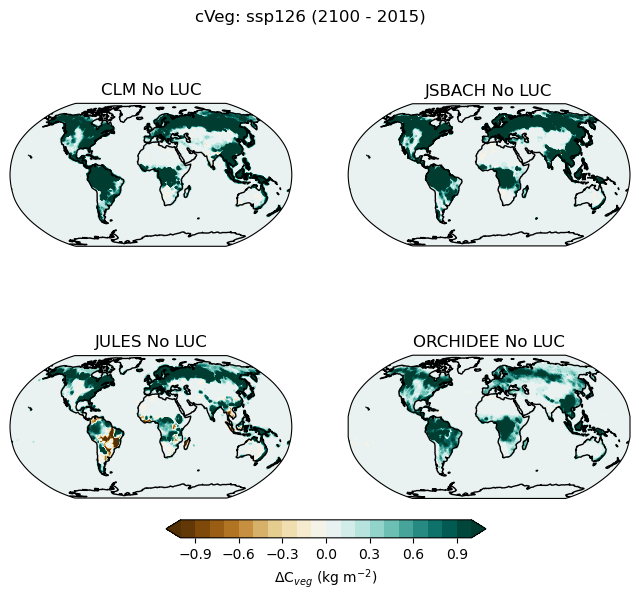

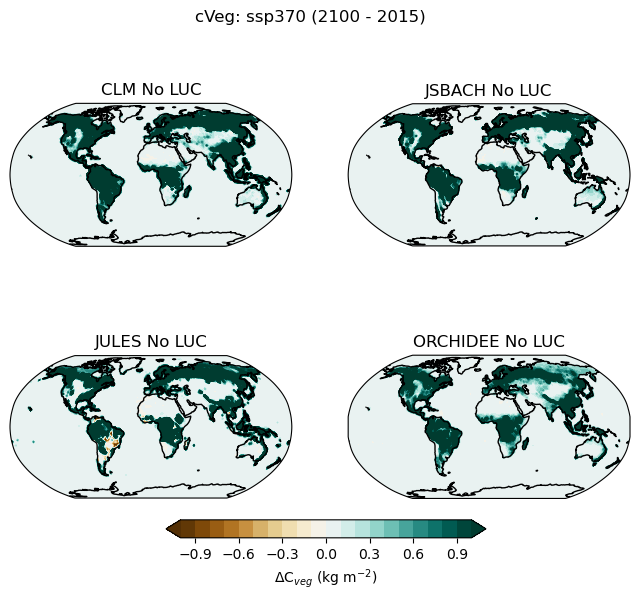

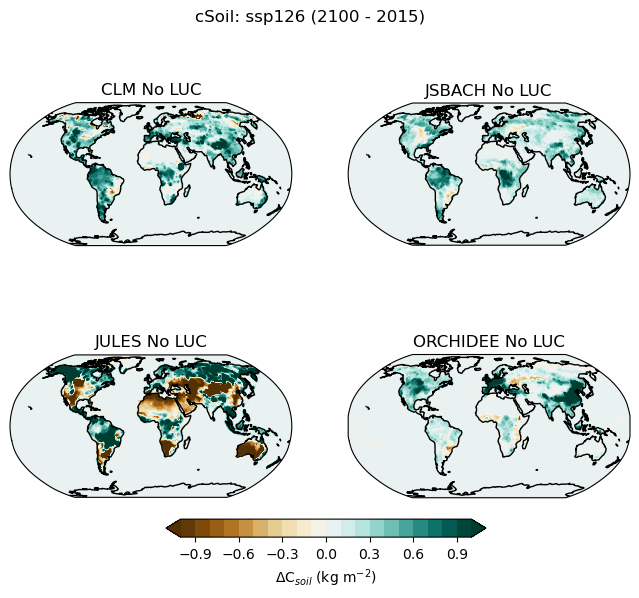

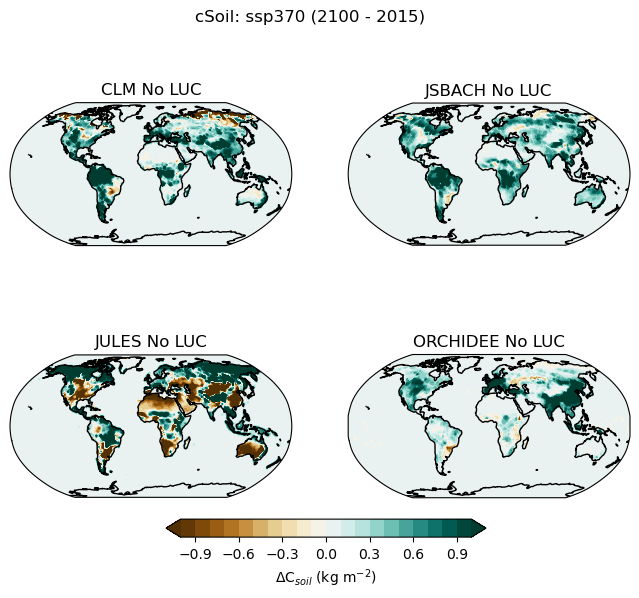

In [10]:
"""
MAIN CODE
First make a set of maps for each variable and SSP with no land use change:
    CLM            JSBACH
    ORCHIDEE       JULES NOLUCAFF
    JULES NOLUCBIO
"""

MODELS=['clm','jsbach','jules','orchidee']
lsm_name=['CLM','JSBACH','JULES','ORCHIDEE']
LANDUSES=['noluc','nolucbio','agtoaff', 'agtonat', 'nattoaff', 'nattobio', 'agtobio']
landuse_name=['No LUC','No LUC: Bioenergy','Ag to Aff','Ag to Ref', \
              'Natural to Aff''Ag to Bioenergy', \
              'Natural to Bioenergy']
SSPS=['ssp126','ssp370']
VARIABLES=['cVeg','cSoil','cProduct','cLitter','cTot']
ESMS=['mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr']
VARIABLES=['cVeg','cSoil','cProduct','cLitter','cTot']
YEARS=['2015','2100']
nMODELS=len(MODELS)
nLANDUSES=len(LANDUSES)

landuse_exists = {lsm: {landuse: [True] for landuse in LANDUSES} for lsm in MODELS}
#The next two should be True/False when making plots for AR
# and False/True when making plots for bioenergy
landuse_exists['jules']['noluc'] = True
landuse_exists['jules']['nolucbio'] = False

#landuse_exists['clm']['nolucaff'] = False
landuse_exists['clm']['nolucbio'] = False
landuse_exists['jsbach']['agtonat'] = False
landuse_exists['jsbach']['nattoaff'] = False
#landuse_exists['jsbach']['nolucaff'] = False
landuse_exists['jsbach']['nolucbio'] = False
landuse_exists['orchidee']['agtobio'] = False
landuse_exists['orchidee']['agtonat'] = False
landuse_exists['orchidee']['nattobio'] = False
#landuse_exists['orchidee']['nolucaff'] = False
landuse_exists['orchidee']['nolucbio'] = False

variable_exists = {var: {lsm: [True] for lsm in MODELS} for var in VARIABLES}
variable_exists['cProduct']['jules'] = False
variable_exists['cLitter']['jules'] = False

MAP_DICT_2015 = {var: {ssp: {landuse: {lsm: [] for lsm in MODELS} 
                  for landuse in LANDUSES} for ssp in SSPS}
                  for var in VARIABLES}

MAP_DICT_2100 = {var: {ssp: {landuse: {lsm: [] for lsm in MODELS} 
                  for landuse in LANDUSES} for ssp in SSPS}
                  for var in VARIABLES}

##########################
# FIRST READ IN THE MAPS
##########################
for landuse in LANDUSES:
    print(landuse)
    
    for var in VARIABLES[0:2]:
   
        for ssp in SSPS:
        
            for lsm in MODELS:  

                if (landuse_exists[lsm][landuse] and variable_exists[var][lsm]):
                    pickle_file=['/bdd/ESM2025/WP10/analysis/files/'+lsm+'_'+var+'_2015_'+ssp+'_'+landuse+'.pkl', \
                                 '/bdd/ESM2025/WP10/analysis/files/'+lsm+'_'+var+'_2100_'+ssp+'_'+landuse+'.pkl']        
                    if Path(pickle_file[1]).is_file():
                        # file exists, we can skip a bunch of steps:
                        #print('read pickle files',pickle_file[0])
                        with open(Path(pickle_file[0]), 'rb') as f1:
                            map_2015 = pickle.load(f1)
                        with open(Path(pickle_file[1]), 'rb') as f2:
                            map_2100 = pickle.load(f2)
                  
                    else:
                        map_2015, map_2100 = get_land_carbon_noiris(var,landuse,lsm,ssp)
                        with open(Path(pickle_file[0]), 'wb') as f1:
                            pickle.dump(map_2015, f1)
                        with open(Path(pickle_file[1]), 'wb') as f2:
                            pickle.dump(map_2100, f2)                        

                    MAP_DICT_2015[var][ssp][landuse][lsm]=map_2015
                    MAP_DICT_2100[var][ssp][landuse][lsm]=map_2100
                             
                    #print(np.min(fracs_2015[0,:,:]),np.max(fracs_2015[0,:,:]))        
                    del(map_2015,map_2100)

###################################
# SECOND MAP THE CHANGE FOR NOLUC
###################################

for var in VARIABLES[0:2]:
    for ssp in SSPS:
        mp_fig,mp_axes=plt.subplots(nrows=2,ncols=2,
                            subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                            figsize=(8,6))   
        pltname='/bdd/ESM2025/WP10/maps/map_nolucAR_'+var+'_'+ssp+'.png'
        mp_axes=mp_axes.flatten()
        ax_ind=0        
        for i0 in range(nMODELS):
            lsm=MODELS[i0]    
            for i1 in range(2):
                landuse=LANDUSES[i1]
                if landuse_exists[lsm][landuse]: 
                    print(landuse,lsm,var,ssp,'make map for axes',ax_ind)
                    land_fraction,lons,lats = get_lsm_data(lsm)
                    maparray = (np.array(MAP_DICT_2100[var][ssp][landuse][lsm].data) - \
                                np.array(MAP_DICT_2015[var][ssp][landuse][lsm]).data)
                    
                    cs = make_map(var,lsm_name[i0],ssp,landuse_name[i1],mp_axes,ax_ind,
                                     np.array(lons),np.array(lats),maparray,mask_between=True)
                    #print(landuse,lsm,'make',map,' for axes',ax_ind)
                    ax_ind+=1
                    del(maparray,land_fraction,lons,lats)  
                    

        #if ax_ind>4: mp_fig.delaxes(mp_axes[ax_ind])    
        # Add a colorbar axis to bottom right
        #cbar_ax = mp_fig.add_axes([0.52, 0.25, 0.4, 0.03])
        cbar_ax = mp_fig.add_axes([0.32, 0.10, 0.4, 0.03])
        # Draw the colorbar
        if var=='cVeg':
            cbar=mp_fig.colorbar(cs, cax=cbar_ax,  
                                 orientation='horizontal', 
                                 label=r'$\Delta$C$_{veg}$ (kg m$^{-2}$)')
        elif var=='cSoil':
            cbar=mp_fig.colorbar(cs, cax=cbar_ax,  
                                 orientation='horizontal', 
                                 label=r'$\Delta$C$_{soil}$ (kg m$^{-2}$)')
        # Add a big title at the top
        print('save the plot:',pltname)
        plt.suptitle(var+': '+ssp+' (2100 - 2015)')
        plt.savefig(pltname,format="png", dpi=400)    
        #plt.close()
        del(cs,mp_fig,mp_axes)


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtoaff-noluc_cVeg_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtonat-noluc_cVeg_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_nattoaff-noluc_cVeg_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtoaff-noluc_cVeg_ssp370.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtonat-noluc_cVeg_ssp370.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_nattoaff-noluc_cVeg_ssp370.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtoaff-noluc_cSoil_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtonat-noluc_cSoil_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_nattoaff-noluc_cSoil_ssp126.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtoaff-noluc_cSoil_ssp370.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_agtonat-noluc_cSoil_ssp370.png


/tmp/ipykernel_2820200/3831326777.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  mp_fig.tight_layout()


save the plot: /bdd/ESM2025/WP10/maps/map_nattoaff-noluc_cSoil_ssp370.png


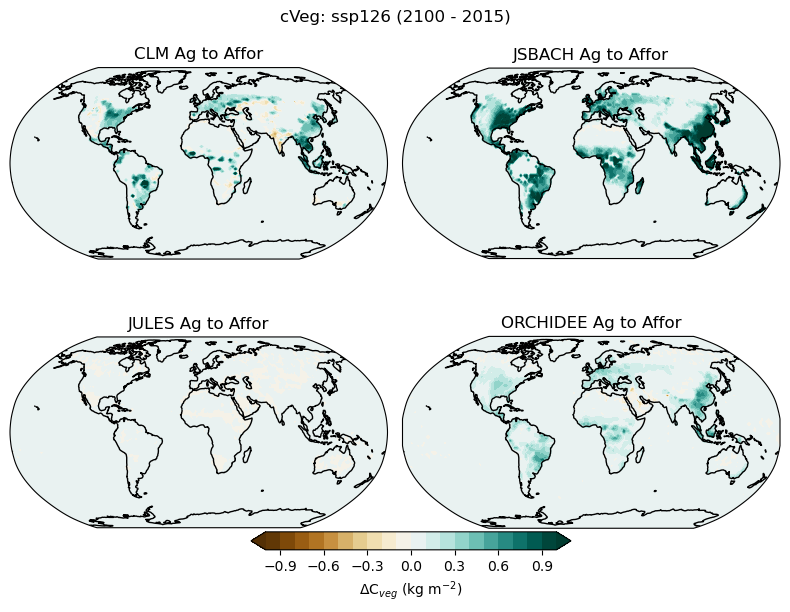

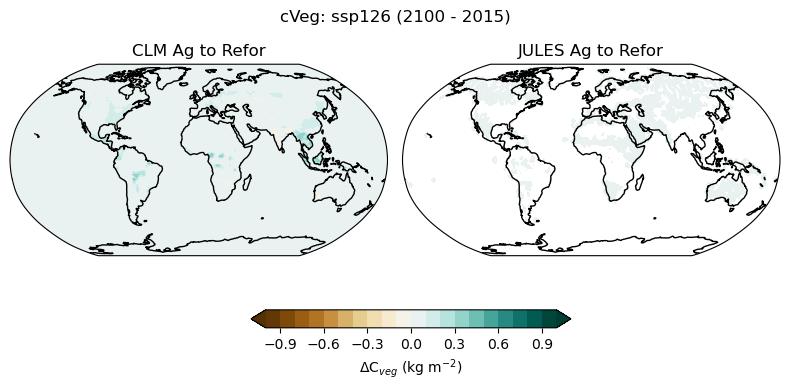

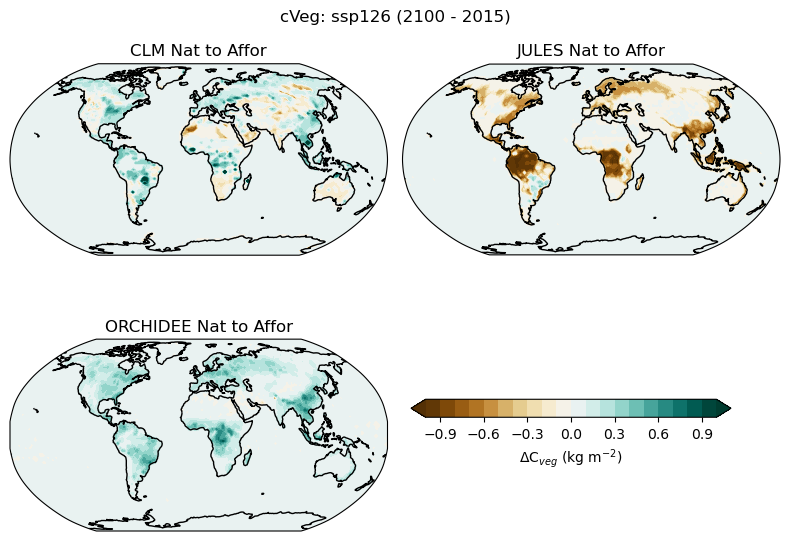

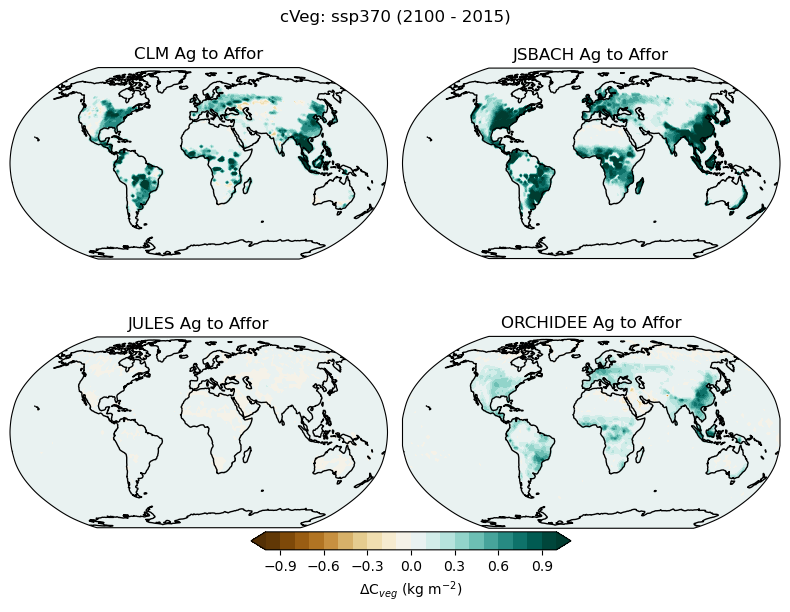

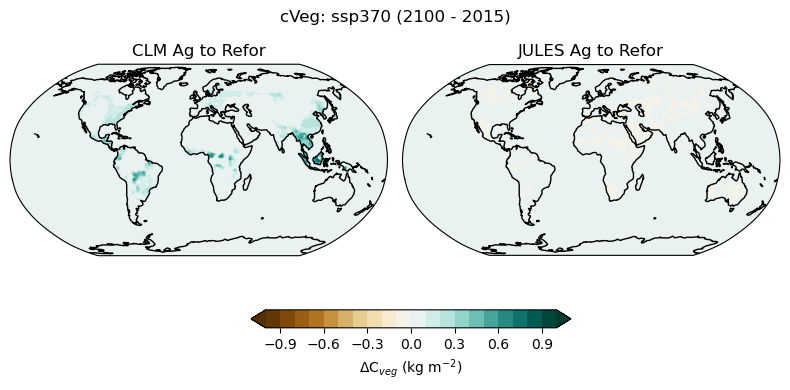

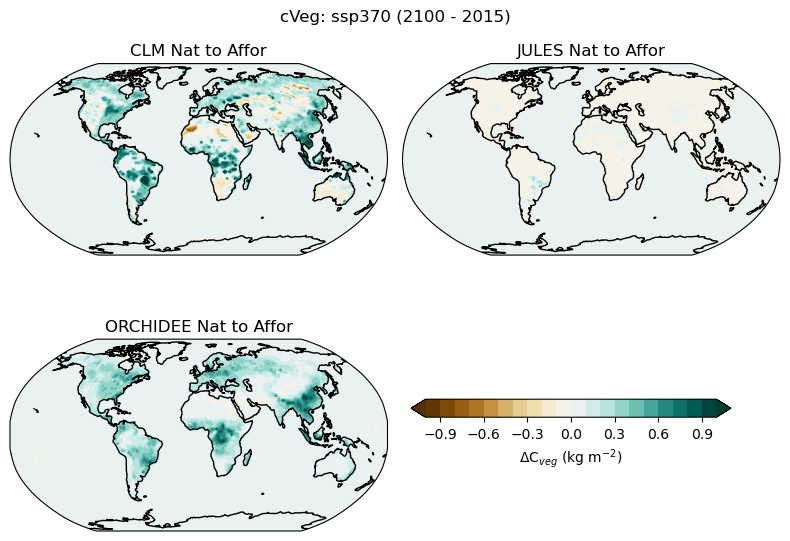

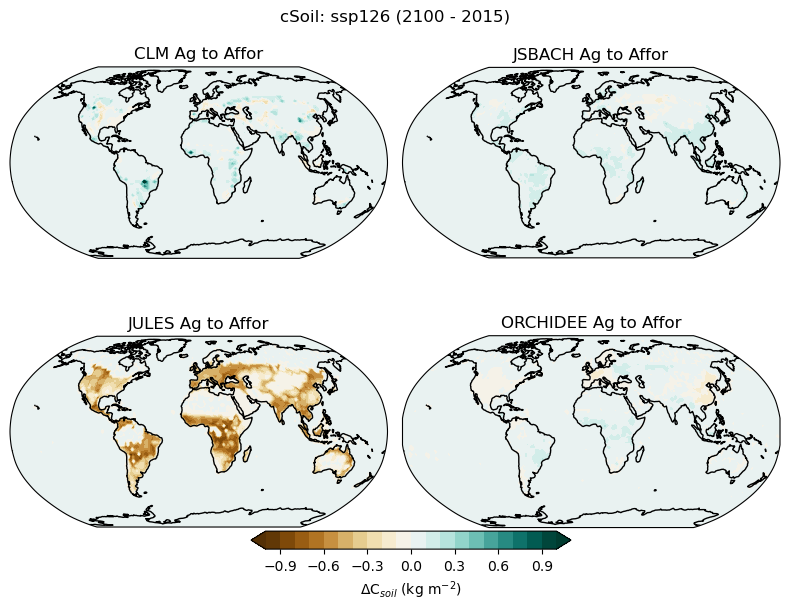

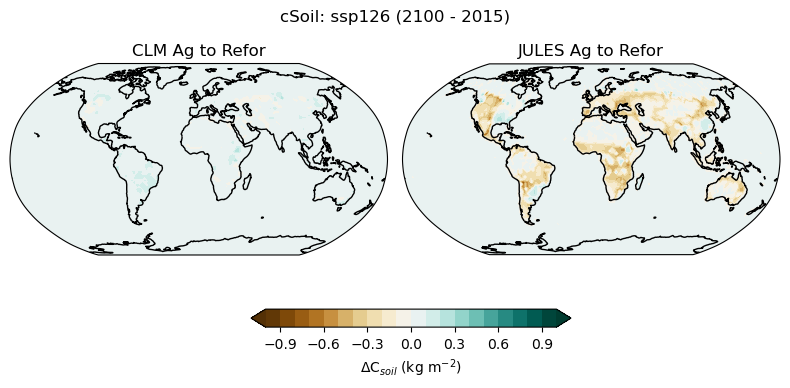

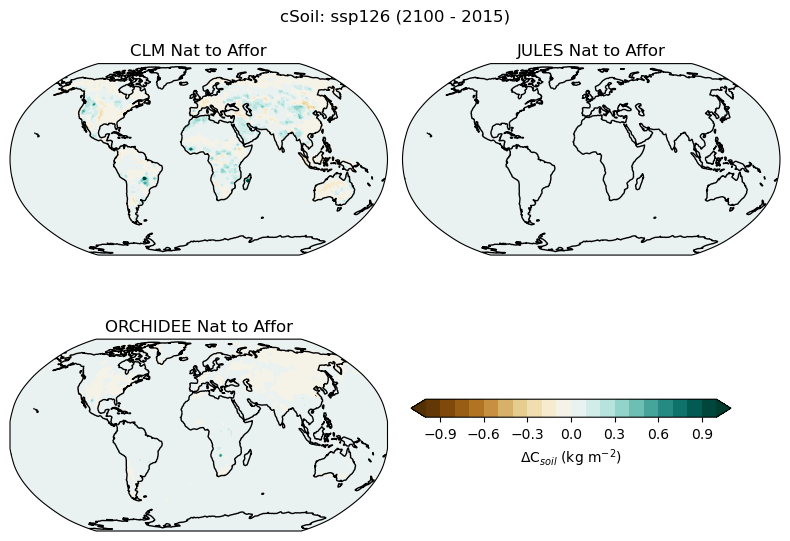

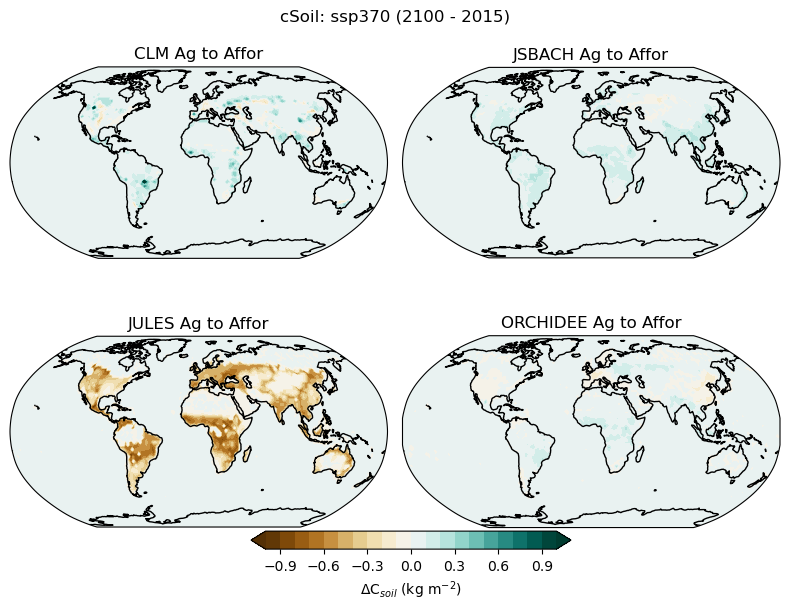

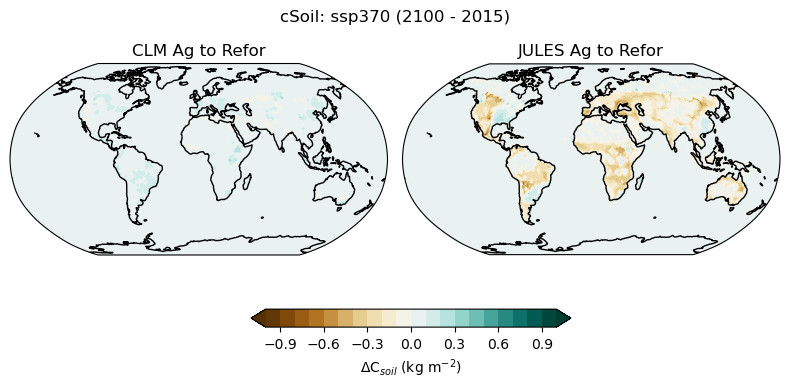

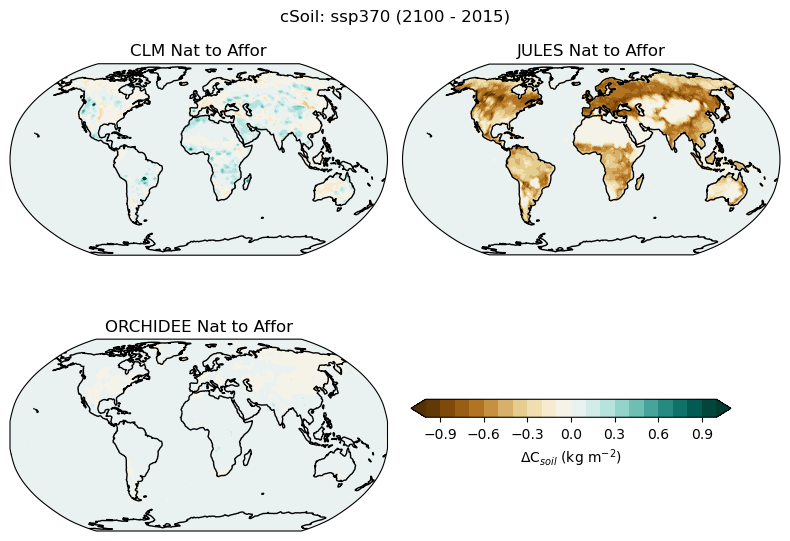

In [33]:
###########################
# THIRD MAP THE  SCENARIO
##########################
LANDUSES=['noluc','nolucbio','agtoaff', 'agtonat', 'nattoaff', 'nattobio', 'agtobio']

landuse_name=['No LUC','No LUC: Bioenergy','Ag to Affor','Ag to Refor', \
              'Nat to Affor','Ag to Bioenergy', \
              'Natural to Bioenergy']
for var in VARIABLES[0:2]:
    for ssp in SSPS:

        for i1 in range(2,5):
            landuse = LANDUSES[i1]
            pltname='/bdd/ESM2025/WP10/maps/map_'+landuse+'-noluc_'+var+'_'+ssp+'.png'
            mp_fig,mp_axes=plt.subplots(nrows=2,ncols=2,
                            subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                            figsize=(8,6))               
            mp_axes=mp_axes.flatten()
            ax_ind=0        
            for i0 in range(nMODELS):
                lsm=MODELS[i0]                   
                if landuse_exists[lsm][landuse]: 
                    #ax,cs = generate_plot(var,model,ssp_id,diff,plotrow,plotcolumn)
                    
                    #print(landuse,lsm,var,ssp,'make map for axes',ax_ind)
                    land_fraction,lons,lats = get_lsm_data(lsm)
                    maparray = (np.array(MAP_DICT_2100[var][ssp][landuse][lsm]) - \
                                np.array(MAP_DICT_2015[var][ssp][landuse][lsm])) - \
                               (np.array(MAP_DICT_2100[var][ssp]['noluc'][lsm]) - \
                                np.array(MAP_DICT_2015[var][ssp]['noluc'][lsm]))                    
                    cs = make_map(var,lsm_name[i0],ssp,landuse_name[i1],mp_axes,ax_ind,
                                     np.array(lons),np.array(lats),maparray,mask_between=True)
                    #print(landuse,lsm,'make',map,' for axes',ax_ind)
                    ax_ind+=1
                    del(maparray,land_fraction,lons,lats)  
                            
            if ax_ind<4: 
                mp_fig.delaxes(mp_axes[ax_ind])
                if (ax_ind==2):
                    mp_fig.delaxes(mp_axes[ax_ind+1])
            # Add a colorbar axis to bottom right
            if (ax_ind==4):
                cbar_ax = mp_fig.add_axes([0.32, 0.08, 0.4, 0.03])                        
            elif (ax_ind==2):
                #Place it bottom center
                cbar_ax = mp_fig.add_axes([0.32, 0.45, 0.4, 0.03])
            elif (ax_ind==3):
                #Bottom right
                cbar_ax = mp_fig.add_axes([0.52, 0.30, 0.4, 0.03])
            # Draw the colorbar
            if var=='cVeg':
                cbar=mp_fig.colorbar(cs, cax=cbar_ax,  
                                     orientation='horizontal', 
                                     label=r'$\Delta$C$_{veg}$ (kg m$^{-2}$)')
            elif var=='cSoil':
                cbar=mp_fig.colorbar(cs, cax=cbar_ax,  
                                     orientation='horizontal', 
                                     label=r'$\Delta$C$_{soil}$ (kg m$^{-2}$)')
            # Add a big title at the top
            mp_fig.tight_layout()
            print('save the plot:',pltname)
            plt.suptitle(var+': '+ssp+' (2100 - 2015)')
            plt.savefig(pltname,format="png", dpi=400)    
            #plt.close()
            del(cs,mp_fig,mp_axes)
